# INITIALIZATION #

In [1]:
import torch
from torch import nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import chi2_contingency
from sklearn.utils import resample
from interception_utils import compare_models, truncate_optic_input, remove_gravity_column, bootstrap_f1_diff, mcnemar_comparison, chi_square_accuracy_by_gravity


ml_input = pd.read_csv('CML_data.csv')

In [2]:
# device agnositc code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()

False

In [3]:
y = ml_input['catch_success'] # we separate our dependent variable, the one we want to predict

theta_cols = [col for col in ml_input.columns if col.startswith('theta_')]
pitch_cols = [col for col in ml_input.columns if col.startswith('pitchBall_')]

# Combine all feature columns
feature_cols = ['G', 'size'] + theta_cols + pitch_cols

# Final input feature matrix
X = ml_input[feature_cols]

print(X.shape)  # Should be (num_trials, num_features)
print(y.value_counts())  # Check how balanced your data is (1 = catch, 0 = no catch)

(9439, 1246)
catch_success
0    6582
1    2857
Name: count, dtype: int64


In [4]:
# divide sample into train and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# scale variables, — fit only on X_train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit (mean calculation) and transform only on training data
X_test_scaled = scaler.transform(X_test)        # apply same scaling to test data, in order to prevent data leakage

# convert data ino tensors for Pytorch use
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)


# CREATING THE MODULARIZED MODEL (so it can be modified on demand) #

## DEFINING THE INNER STRUCTURE OF THE NEURAL NETWORK ##

In [5]:
class InterceptionNet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 64], dropout_p=0.3):
        super().__init__()

        # We'll store the layers in this list before wrapping them into a Sequential module
        layers = []
        
        #input_dim automatically does behind the hood: input_dim = X_train.shape[1]
        # Start with the input dimension
        prev_dim = input_dim

        # Build all hidden layers based on the list [64, 64], or any other configuration
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))    # Fully connected layer
            layers.append(nn.BatchNorm1d(h))         # Batch normalization, normalizes the h outputs from the previous linear layer.  
            layers.append(nn.PReLU())                # Activation function
            layers.append(nn.Dropout(p=dropout_p))   # Dropout for regularization
            prev_dim = h                             # Set current layer size as input for next

        # Final output layer: always maps to 1 logit (key for binary classification)
        layers.append(nn.Linear(prev_dim, 1))

        # Wrap all the layers into a single nn.Sequential model
        # *layers unpacks the list — like saying: nn.Sequential(layer1, layer2, ..., layerN)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass input through the entire model (which is a stack of layers)
        return self.model(x)

## DEFINING THE POSSIBLE LOSS FUNCTION AND OPTIMIZER ##

In [6]:
def get_loss_fn(pos_weight=None):
    # If a positive weight is given (for class imbalance)
    if pos_weight is not None:
        # Create a 1-element tensor with the weight, and move it to the same device as the model
        weight_tensor = torch.tensor([pos_weight], device=device)

        # Use the weighted version of binary cross-entropy with logits
        return nn.BCEWithLogitsLoss(pos_weight=weight_tensor)
    else:
        # No class weighting — use default loss
        return nn.BCEWithLogitsLoss()

def get_optimizer(model, optimizer_name='adam', lr=1e-3, weight_decay=0.0):
    # Normalize the input string so 'Adam', 'ADAM', 'adam' all work the same
    if optimizer_name.lower() == 'adam':
        return torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    elif optimizer_name.lower() == 'sgd':
        return torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    else:
        # If you enter an unsupported optimizer name, raise an error
        raise ValueError("Unsupported optimizer: choose 'adam' or 'sgd'")

## DEFINING THE MODEL TRAINING AND EVALUATION ##

In [7]:
def train_model(model, loss_fn, optimizer, 
                X_train, y_train, X_test, y_test, 
                epochs = 100, threshold = 0.5):

    # Prepare lists to store training progress
    epoch_count = []
    train_losses = []
    test_losses = []
    f1_scores = []
    auc_scores = []
    recall_scores = []
    precision_scores = []
    test_preds = []

    torch.manual_seed(42)

    for epoch in range(epochs):

        epoch_count.append(epoch)

        ### TRAINING PHASE ###
        model.train()  # Enable dropout, gradients, etc.

        # Forward pass on training data
        y_logits = model(X_train)
        y_pred = torch.round(torch.sigmoid(y_logits))

        loss = loss_fn(y_logits, y_train) # calculate loss on train sets

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ### EVALUATION PHASE ###
        model.eval()  # Disable dropout, gradients etc.
        with torch.inference_mode():
                test_logits = model(X_test)
                test_probs = torch.sigmoid(test_logits)
                test_pred = (test_probs >= threshold).int()

                # Convert to CPU numpy for sklearn
                y_true_np = y_test.cpu().numpy()
                y_prob_np = test_probs.cpu().numpy()             
                y_pred_np = test_pred.cpu().numpy() 

                test_loss = loss_fn(test_logits, y_test) # calculate loss on test sets
                                
                # Calculate the needed metrics
                test_f1 = f1_score(y_true_np, y_pred_np)
                test_auc = roc_auc_score(y_true_np, y_prob_np)
                test_recall = recall_score(y_true_np, y_pred_np, zero_division=0)
                test_precision = precision_score(y_true_np, y_pred_np, zero_division=0)
                test_cm = confusion_matrix(y_true_np, y_pred_np)

        # Append metrics to pre-created lists 
        f1_scores.append(test_f1)
        auc_scores.append(test_auc)
        recall_scores.append(test_recall)
        precision_scores.append(test_precision)
        train_losses.append(loss.item()) # .item() necessary to convert scalar tensor into plain Python float
        test_losses.append(test_loss.item()) # .item() necessary to convert scalar tensor into plain Python float
        test_preds.append(y_pred_np)


        #Print model situation at certain epochs
        if epoch in [0, epochs // 2, epochs - 1]:
            print(f"Epoch {epoch:>3} | "
            f"Train Loss: {loss.item():.4f} | Test Loss: {test_loss.item():.4f} | "
            f"F1: {test_f1:.3f} | AUC: {test_auc:.3f} | "
            f"Recall: {test_recall:.3f} | Precision: {test_precision:.3f}") 
                                       
            if epoch == epochs - 1:
                print(f"Confusion Matrix:\n{test_cm}")

    return {
        'model': model,
        'epochs': epoch_count,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'f1_scores': f1_scores,
        'auc_scores': auc_scores,
        'recall_scores': recall_scores,       
        'precision_scores': precision_scores,
        'y_true': y_true_np,
        'y_prob': y_prob_np,
        'test_preds': test_preds       
    }

## FITTING IT ALL TOGETHER INTO A FUNCTION ##

In [8]:
def run_experiment(X_train, y_train, X_test, y_test,
                   hidden_dims=[64, 64],
                   dropout_p=0.3,
                   optimizer_name='adam',
                   lr=1e-3,
                   weight_decay=1e-4,
                   pos_weight=None,
                   epochs=100,
                   threshold = 0.5,
                   device='cpu'
                   ):
                   
    # Build the model
    model = InterceptionNet(input_dim=X_train.shape[1],
                        hidden_dims=hidden_dims,
                        dropout_p=dropout_p).to(device)


    # Create the loss function
    loss_fn = get_loss_fn(pos_weight=pos_weight)

    # Create the optimizer
    optimizer = get_optimizer(model,
                              optimizer_name=optimizer_name,
                              lr=lr,
                              weight_decay=weight_decay)

    # Train using existing train_model() function
    return train_model(model=model,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       X_train=X_train, y_train=y_train,
                       X_test=X_test, y_test=y_test,
                       epochs=epochs,
                       threshold = threshold
                       )

# HYPOTHESIS TESTING #

Epoch   0 | Train Loss: 0.9955 | Test Loss: 0.9711 | F1: 0.000 | AUC: 0.531 | Recall: 0.000 | Precision: 0.000
Epoch  75 | Train Loss: 0.7632 | Test Loss: 0.8741 | F1: 0.579 | AUC: 0.745 | Recall: 0.750 | Precision: 0.471
Epoch 149 | Train Loss: 0.7348 | Test Loss: 0.9038 | F1: 0.589 | AUC: 0.744 | Recall: 0.802 | Precision: 0.465
Confusion Matrix:
[[791 526]
 [113 458]]


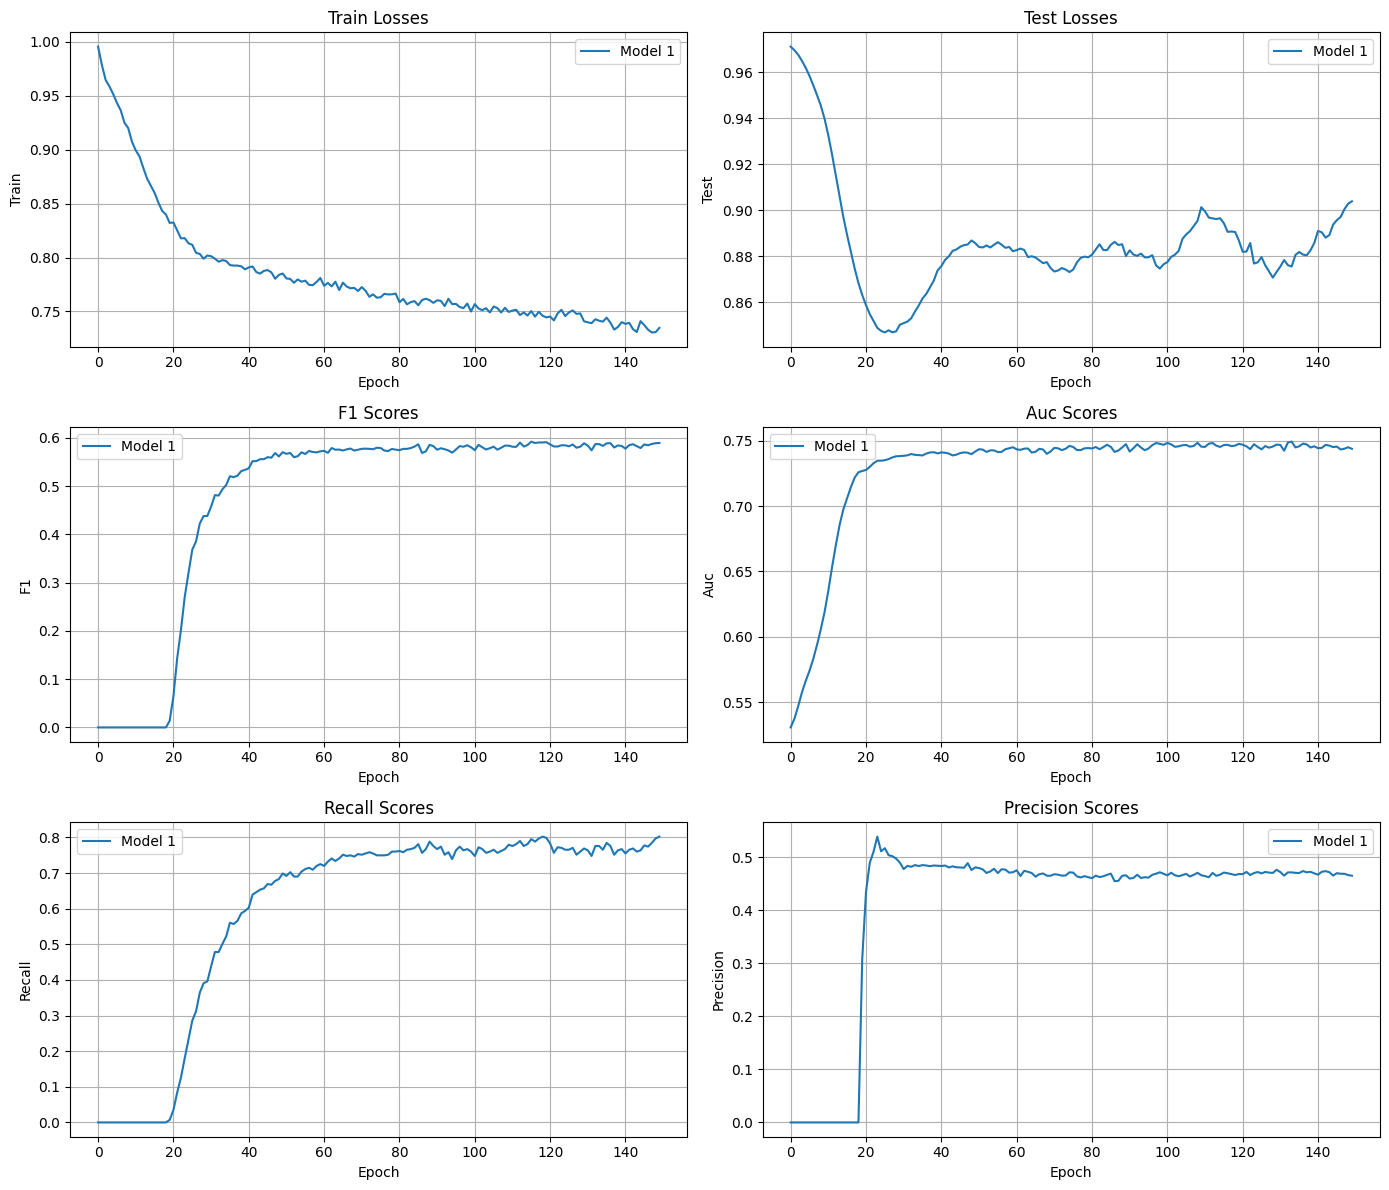

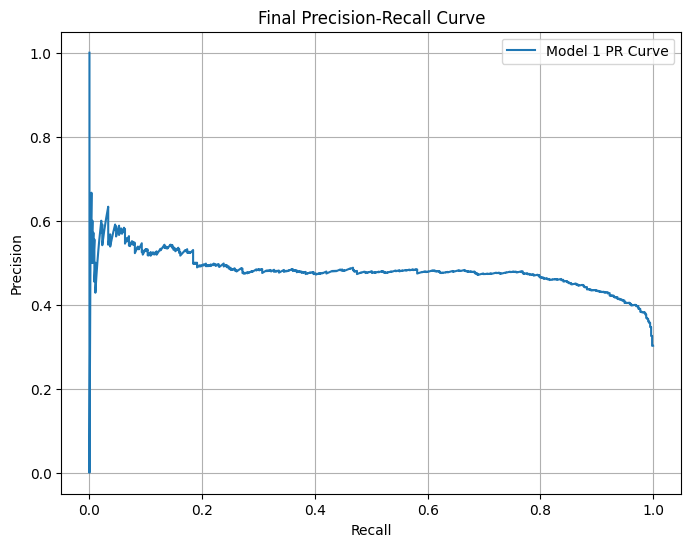

In [9]:
final_model = run_experiment(
    X_train, y_train, X_test, y_test,
    hidden_dims=[128, 64, 64],
    dropout_p=0.2,
    optimizer_name='adam',
    lr=1e-3,
    weight_decay=1e-4,
    pos_weight=2.33,
    epochs=150,
    threshold = 0.6,
    device=device
)

compare_models(final_model)

## CHECKING THE SECOND HYPOTHESIS ##

In [10]:
# Define truncation ratios to test (from full length down to 10%)
# ratios_to_test = [1.0, 0.75, 0.5, 0.4, 0.35, 0.3, 0.2, 0.1]
ratios_to_test = [1.0, 0.4, 0.35, 0.3, 0.2]

# Dictionary to collect results
results = {
    'keep_ratio': [],
    'f1': [],
    'recall': [],
    'precision': [],
    'auc': [],
    'test_preds': []
}

# Loop through each truncation ratio
for ratio in ratios_to_test:
    print(f"\nTesting keep_ratio: {ratio*100:.0f}%")

    # Truncate input
    X_train_cut = torch.tensor(truncate_optic_input(X_train, keep_ratio=ratio), dtype=torch.float32)
    X_test_cut = torch.tensor(truncate_optic_input(X_test, keep_ratio=ratio), dtype=torch.float32)

    # Train the model
    model = run_experiment(
        X_train_cut, y_train, X_test_cut, y_test,
        hidden_dims=[128, 64, 64],
        dropout_p=0.2,
        optimizer_name='adam',
        lr=1e-3,
        weight_decay=1e-4,
        pos_weight=2.33,
        epochs=150,
        threshold = 0.6,
        device=device
    )

    # Unpack metrics from the returned model
    f1 = model['f1_scores']
    recall = model['recall_scores']
    precision = model['precision_scores']
    auc = model['auc_scores']
    test_preds = model['test_preds']

    # Store results in the pre-created dictionary
    results['keep_ratio'].append(ratio)
    results['f1'].append(f1)
    results['recall'].append(recall)
    results['precision'].append(precision)
    results['auc'].append(auc)
    results['test_preds'].append(test_preds)

# Convert to pandas DataFrame for easier analysis
results_df = pd.DataFrame(results)


Testing keep_ratio: 100%
Epoch   0 | Train Loss: 0.9922 | Test Loss: 0.9693 | F1: 0.003 | AUC: 0.524 | Recall: 0.002 | Precision: 0.500
Epoch  75 | Train Loss: 0.7640 | Test Loss: 0.8437 | F1: 0.570 | AUC: 0.746 | Recall: 0.736 | Precision: 0.465
Epoch 149 | Train Loss: 0.7325 | Test Loss: 0.8510 | F1: 0.565 | AUC: 0.743 | Recall: 0.725 | Precision: 0.463
Confusion Matrix:
[[837 480]
 [157 414]]

Testing keep_ratio: 40%
Epoch   0 | Train Loss: 1.0050 | Test Loss: 0.9715 | F1: 0.003 | AUC: 0.525 | Recall: 0.002 | Precision: 0.500
Epoch  75 | Train Loss: 0.7879 | Test Loss: 0.8552 | F1: 0.567 | AUC: 0.746 | Recall: 0.697 | Precision: 0.478
Epoch 149 | Train Loss: 0.7712 | Test Loss: 0.8692 | F1: 0.580 | AUC: 0.746 | Recall: 0.753 | Precision: 0.471
Confusion Matrix:
[[834 483]
 [141 430]]

Testing keep_ratio: 35%
Epoch   0 | Train Loss: 1.0025 | Test Loss: 0.9734 | F1: 0.000 | AUC: 0.473 | Recall: 0.000 | Precision: 0.000
Epoch  75 | Train Loss: 0.8186 | Test Loss: 0.9293 | F1: 0.530 | 

In [11]:
preds_100 = results_df[results_df['keep_ratio'] == 1.0]['test_preds'].values[0][-1] # get the prediction of the desired length
preds_40 = results_df[results_df['keep_ratio'] == 0.4]['test_preds'].values[0][-1]
preds_35 = results_df[results_df['keep_ratio'] == 0.35]['test_preds'].values[0][-1]
preds_30 = results_df[results_df['keep_ratio'] == 0.30]['test_preds'].values[0][-1]

bootstrap_f1_diff(y_true = y_test, y_pred_full = preds_100, y_pred_cut = preds_40, n_boot=1000) # run the bootstrap and obtain the 95% CI
bootstrap_f1_diff(y_true = y_test, y_pred_full = preds_100, y_pred_cut = preds_35, n_boot=1000)
bootstrap_f1_diff(y_true = y_test, y_pred_full = preds_100, y_pred_cut = preds_30, n_boot=1000)

95% CI is[-0.0309, 0.0029]
No significant difference
95% CI is[-0.0084, 0.0319]
No significant difference
95% CI is[0.0180, 0.0638]
Significant difference


(np.float64(0.01798367872513573), np.float64(0.06380032648945806))

In [12]:
## McNemar's test --> no statistically significant difference in the classification decisions made by the full-input model vs the 35% input model

mcnemar_comparison(y_test, preds_100, preds_30, label_a="100%", label_b="30%")
mcnemar_comparison(y_test, preds_100, preds_35, label_a="100%", label_b="35%")

mcnemar_comparison(y_test, preds_100, preds_40, label_a="100%", label_b="40%")


McNemar Contingency Table (100% vs 30%):
[[1082  169]
 [ 150  487]]
McNemar p-value (100% vs 30%): 0.3135
No significant difference in classification decisions.

McNemar Contingency Table (100% vs 35%):
[[1136  115]
 [ 123  514]]
McNemar p-value (100% vs 35%): 0.6500
No significant difference in classification decisions.

McNemar Contingency Table (100% vs 40%):
[[1171   80]
 [  93  544]]
McNemar p-value (100% vs 40%): 0.3616
No significant difference in classification decisions.


## TEST WHETHER DIFFERENT GRAVITIES AFFECT INTERCEPTION SUCCESS PREDICTION ##

In [13]:
### TRAINING THE BEST MODEL WITH EACH DIFFERENT GRAVITY SEPARATED ###

# Set the trained model into evaluation mode and rerun it
final_model['model'].eval()
with torch.no_grad():
    logits = final_model['model'](X_test)
    probs = torch.sigmoid(logits)
    preds_all = (probs > 0.6).int().cpu().numpy()

# Extract gravity values
G_column = X_test[:, 0].cpu().numpy()  # Gravity is first feature

# identify unique gravity levels in the test set
unique_G = np.unique(G_column)

# convert to numpy for scikit-learn
y_test_np = y_test.cpu().numpy()
y_prob = probs.cpu().numpy()

# Store results
gravity_results = {}

# Evaluate performance per gravity, loop per gravity level and evaluate model performance
print("Performance by Gravity Level:\n")
for g in unique_G:
    mask = G_column == g # Create a mask to filter test samples with gravity level g
    
    # Select labels, predictions, and probabilities for this gravity level
    y_true_g = y_test_np[mask]
    y_pred_g = preds_all[mask]
    y_prob_g = y_prob[mask]

    # Compute evaluation metrics
    f1 = f1_score(y_true_g, y_pred_g)
    recall = recall_score(y_true_g, y_pred_g)
    precision = precision_score(y_true_g, y_pred_g)
    auc = roc_auc_score(y_true_g, y_prob_g)

    gravity_results[g] = { # store results in a dictionary
        'y_true': y_true_g,
        'y_pred': y_pred_g,
        'f1': f1,
        'recall': recall,
        'precision': precision,
        'auc': auc
    }
    
    # print the results
    print(f"G = {g:.1f} → F1: {f1:.3f}, AUC: {auc:.3f}, Recall: {recall:.3f}, Precision: {precision:.3f}")

Performance by Gravity Level:

G = -1.2 → F1: 0.592, AUC: 0.741, Recall: 0.804, Precision: 0.468
G = -0.0 → F1: 0.577, AUC: 0.737, Recall: 0.773, Precision: 0.461
G = 1.2 → F1: 0.598, AUC: 0.757, Recall: 0.832, Precision: 0.467


In [14]:
### Runs a chi-square test to determine if prediction accuracy differs across gravity levels ###

chi_square_accuracy_by_gravity(X_test, y_test, preds_all)


Contingency Table [Correct / Incorrect vs Gravity Level]:
[[422 408 419]
 [215 224 200]]

Chi-square statistic: 1.3745
Degrees of freedom: 2
P-value: 0.5029
No significant association between gravity and prediction accuracy.


In [15]:
# Create input without gravity
X_train_noG = remove_gravity_column(X_train)
X_test_noG = remove_gravity_column(X_test)

model_noG = run_experiment(
    X_train_noG, y_train, X_test_noG, y_test,
    hidden_dims=[128, 64, 64],
    dropout_p=0.2,
    optimizer_name='adam',
    lr=1e-3,
    weight_decay=1e-4,
    pos_weight=2.33,
    epochs=150,
    threshold=0.6,
    device=device
)

Epoch   0 | Train Loss: 0.9922 | Test Loss: 0.9693 | F1: 0.003 | AUC: 0.527 | Recall: 0.002 | Precision: 0.500
Epoch  75 | Train Loss: 0.7666 | Test Loss: 0.8515 | F1: 0.566 | AUC: 0.746 | Recall: 0.715 | Precision: 0.468
Epoch 149 | Train Loss: 0.7322 | Test Loss: 0.8699 | F1: 0.557 | AUC: 0.745 | Recall: 0.701 | Precision: 0.462
Confusion Matrix:
[[851 466]
 [171 400]]


## CALCULATE IF GRAVITY VS. NO GRAVITY HAS AN IMPACT ON THE MODEL PREDICTIONS ##

In [16]:
# Get original full-gravity model
model_G = final_model['model']
model_noG = model_noG['model']

# Predict
def get_preds(model, X): # create this small function to avoid repeating the code twice.
    model.eval()
    with torch.no_grad():
        logits = model(X)
        probs = torch.sigmoid(logits).cpu().numpy()
        return (probs > 0.6).astype(int)

preds_G = get_preds(model_G, X_test)
preds_noG = get_preds(model_noG, X_test_noG)

In [17]:
ci_low, ci_high = bootstrap_f1_diff(
    y_true = y_test.cpu().numpy(),
    y_pred_full = preds_G,
    y_pred_cut = preds_noG
)

95% CI is[0.0173, 0.0490]
Significant difference
